# ⭐️ Raw and Manual Bias Correction Modelling

Import all the required packages.

In [1]:
import sys

sys.path.append("./preprocessing_utils")
sys.path.append("./feature_selection_utils")
sys.path.append("./visual_utils")
sys.path.append("./experiment_utils")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import shap
import pickle
import experiments_utils
import feature_selection
import preprocessing
import visual

# configure pandas settings for data display
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## 📂 Data Preparation

Load the dataset.

In [3]:
df_endo = pd.read_csv(experiments_utils.ENDO_DATA_PREDICTION_PATH)

Split the data into training and test sets.

In [4]:
X = df_endo[experiments_utils.FEATURES_BASELINE_PREDICTION]
y = df_endo["has_endometriosis"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [6]:
print(f"There are {len(y_train)} train and test {len(y_test)} data samples.")
print(
    f"Train dataset contains {y_train.sum()} diagnosed with endometrios participants and test dataset - {y_test.sum()}."
)

There are 386 train and test 166 data samples.
Train dataset contains 165 diagnosed with endometrios participants and test dataset - 64.


In [7]:
X_train, X_test = preprocessing.impute_features(X_train, X_test)

## 📊 Baseline Logistic Regression

The following code blocks outline the derivation of coefficients and p-values for the endometriosis predictor features, which are used in the Section 4.7 (Data Analysis) of this thesis.

In [8]:
baseline_features = [
    feat
    for feat in experiments_utils.FEATURES_BASELINE_PREDICTION
    if feat != "family_history_endometriosis_prediction"
] + ["family_history_endometriosis"]

X_baseline = df_endo[baseline_features]
y_baseline = df_endo["has_endometriosis"]

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.3, random_state=42
)

X_train_baseline, X_test_baseline = preprocessing.impute_features(
    X_train_baseline, X_test_baseline
)

In [11]:
lr_model = feature_selection.run_baseline_logistic_reg(
    X_train_baseline, y_train_baseline
)

Maximum Likelihood optimization failed to converge. Check mle_retvals


Average F1-score across folds: 0.6830676786843771


In [13]:
print(lr_model.summary())

                           Logit Regression Results                           
Dep. Variable:      has_endometriosis   No. Observations:                  386
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                           70
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                  0.4767
Time:                        19:11:22   Log-Likelihood:                -137.87
converged:                       True   LL-Null:                       -263.48
Covariance Type:            nonrobust   LLR p-value:                 3.022e-22
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
age_18_24                                    -1.4577      0.876     -1.665      0.096      -3.174       0.259
age_25_34                             

## 🏋️‍♀️ Model Training on the Entire Feature Set

Predictive models were trained on all available features for early diagnosis to obtain SHAP rankings and feature interpretations. The results are presented in Section 6.2 (Identifying Features Predictive of Endometriosis).

### Logistic Regression

In [18]:
lr_model_base, lr_val_folds_base = feature_selection.run_logistic_regression(
    X_train, y_train, disp=True
)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Avg F1 Score: 0.7130833309032941


### Random Forest

In [19]:
rf_model_base, rf_val_folds_base = feature_selection.run_rf(X_train, y_train, disp=True)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Avg F1 Score: 0.7352424708679888


### XGBoost

In [20]:
xgboost_model_base, xgb_val_folds_base = feature_selection.run_xgb(
    X_train, y_train, disp=True
)

Best Hyperparameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.7}
Avg F1 Score: 0.7420184114137982


### AdaBoost

In [21]:
ada_model_base, ada_val_folds_base = feature_selection.run_ada(
    X_train, y_train, disp=True
)

Best Hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.05, 'n_estimators': 100}
Avg F1 Score: 0.7416180524004241


### MLP

In [22]:
mlp_model_base, mlp_val_folds_base = feature_selection.run_mlp(
    X_train, y_train, disp=True
)

Best Hyperparameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__beta_1': 0.95, 'mlp__beta_2': 0.999, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01, 'mlp__max_iter': 500, 'mlp__solver': 'adam'}
Avg F1 Score: 0.7486412354679715


### TabPFN

Due to TabPFN's need for GPU resources to facilitate faster training, it was executed within a GPU-enabled Google Colaboratory environment: [TabPFN_endometriosis_experiment.ipynb](https://colab.research.google.com/drive/1S9i1o-kvCWtUDNY7kDj0AAR88KAaJCEo#scrollTo=FXdTtXVeqzgD).

The average cross-validation score achieved is 73.90%.

## ⬆️ SHAP (Feature Interpretations among Models)

To visualize feature importance, summary SHAP plots were generated for each trained model. The Random Forest and XGBoost summary plots are further analyzed in Section 6.2.2 (Feature Interpretation).

#### Random Forest

In [23]:
shap_values_rf, shap_importance_rf = feature_selection.get_shap_importance(
    X_train, rf_model_base
)

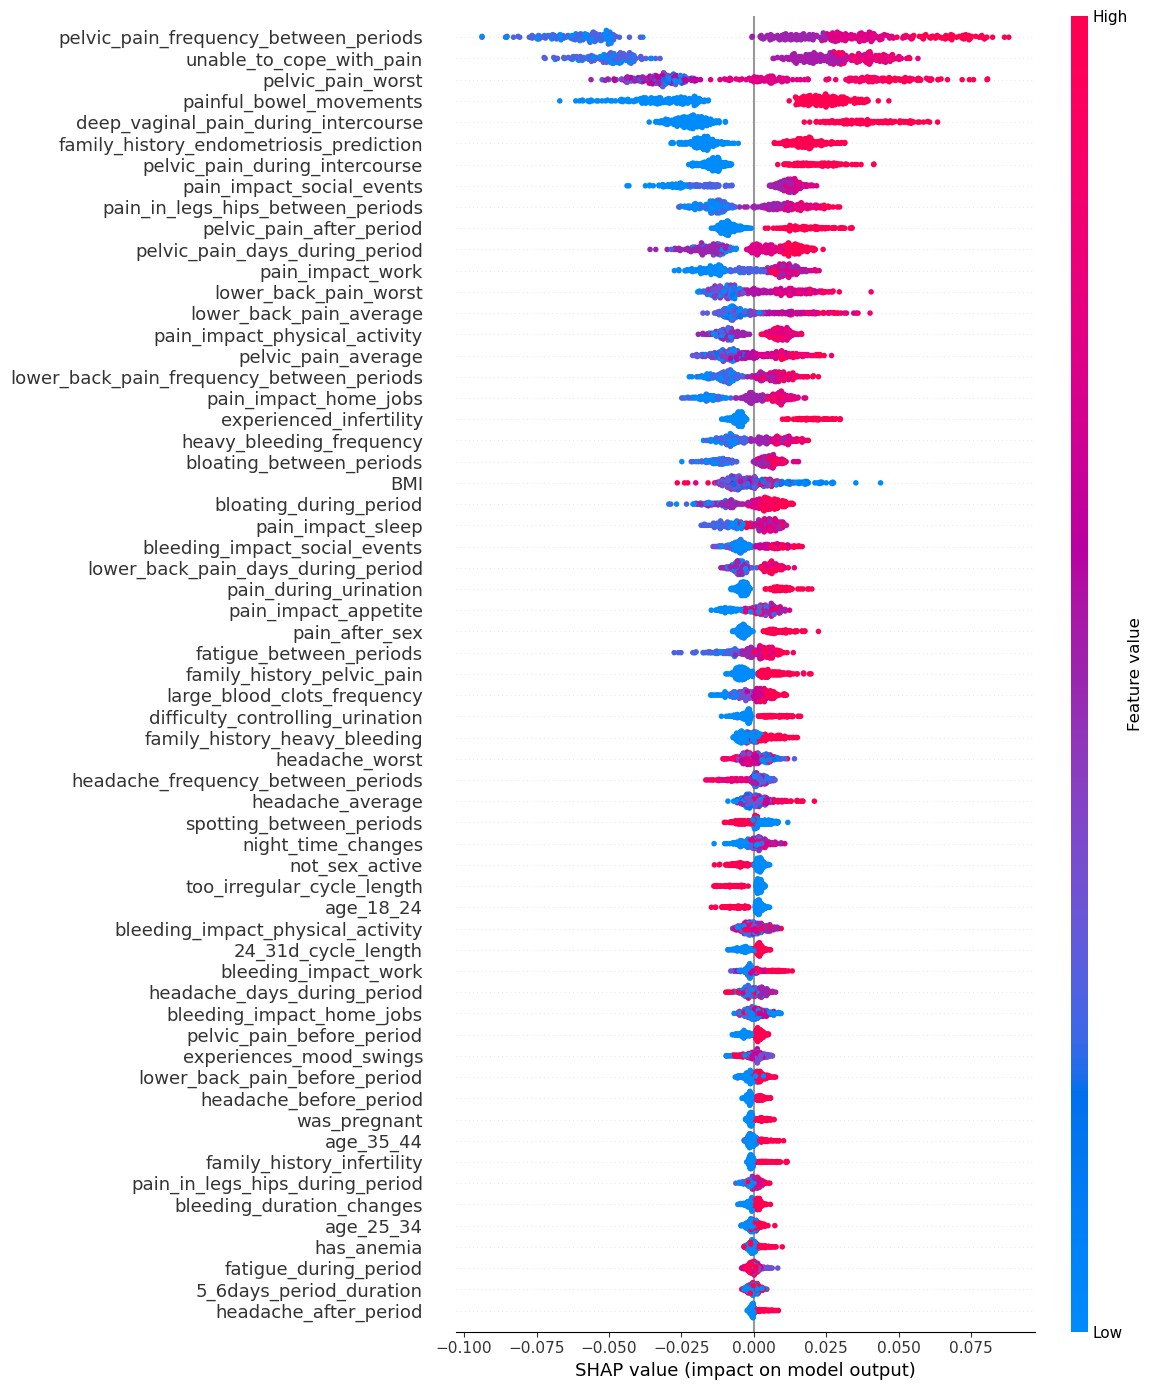

In [24]:
shap.summary_plot(shap_values_rf[:, :, 1], X_train, plot_size=[12, 14], max_display=61)

#### XGBoost

In [25]:
shap_values_xgb, shap_importance_xgb = feature_selection.get_shap_importance(
    X_train, xgboost_model_base
)

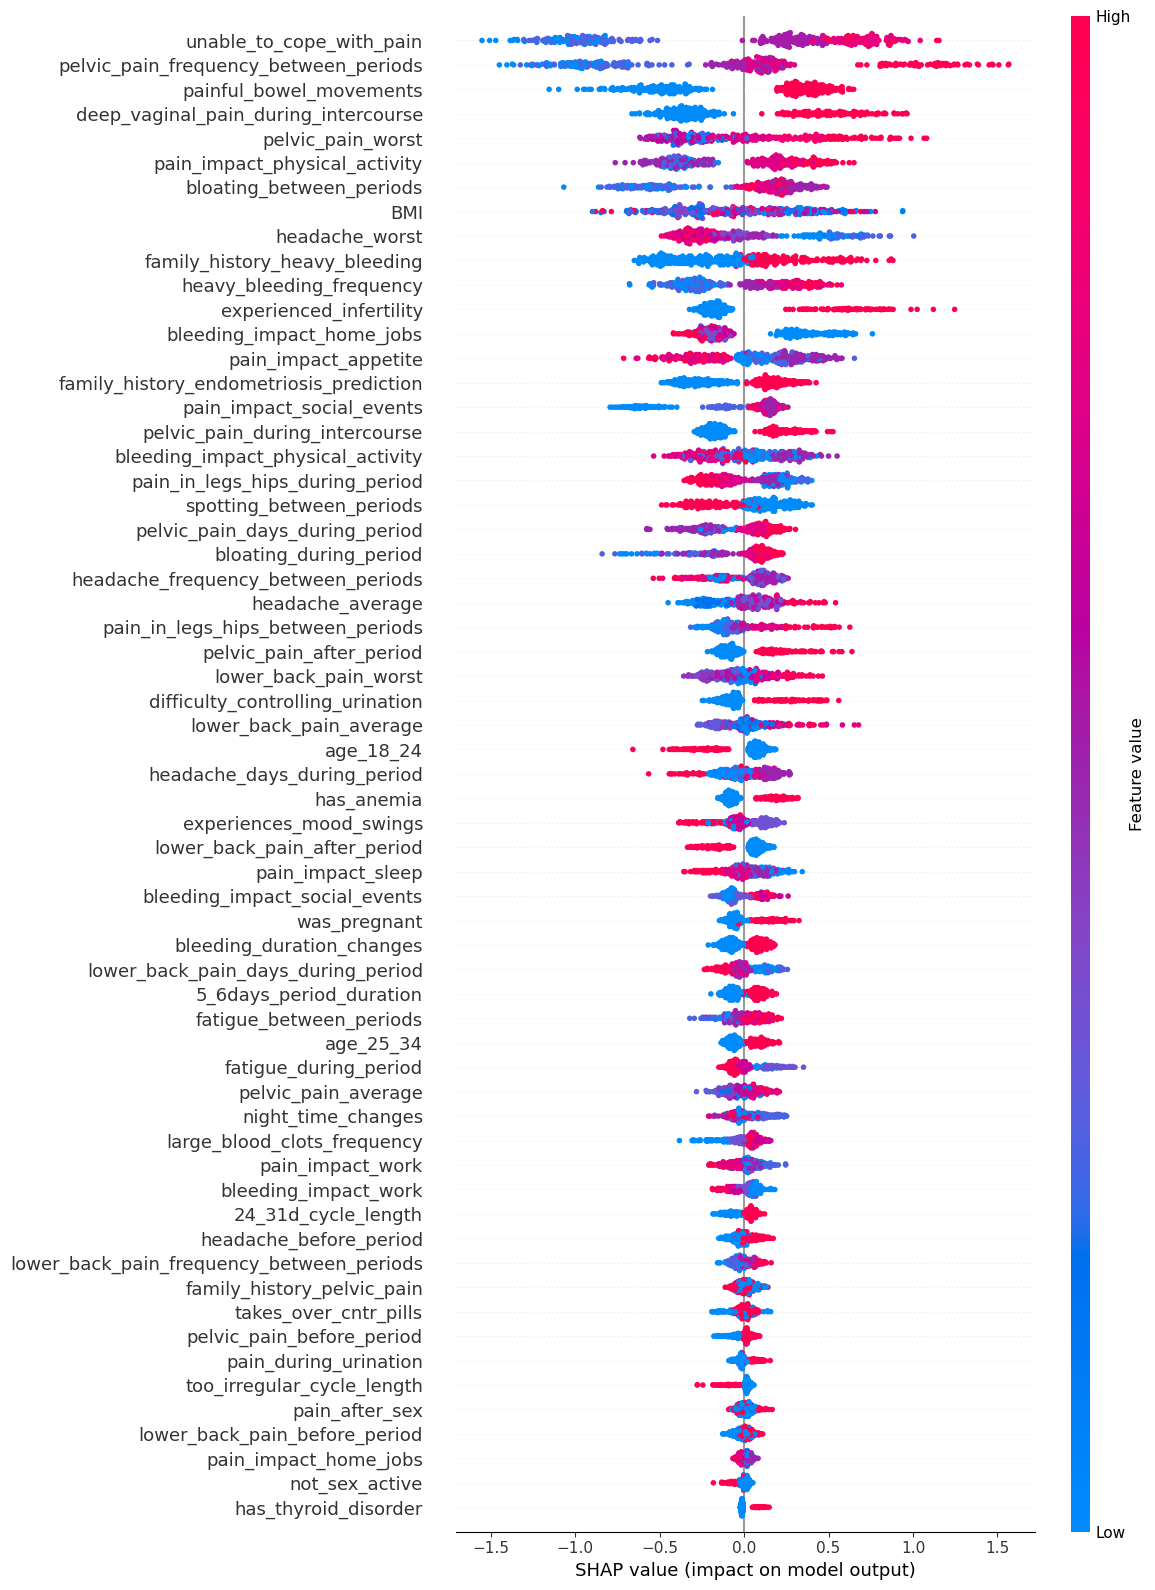

In [26]:
shap.summary_plot(shap_values_xgb, X_train, plot_size=[12, 16], max_display=61)

#### AdaBoost

In [27]:
shap_values_ada, shap_importance_ada = feature_selection.get_shap_importance(
    X_train, ada_model_base
)

PermutationExplainer explainer: 387it [01:10,  4.81it/s]                         


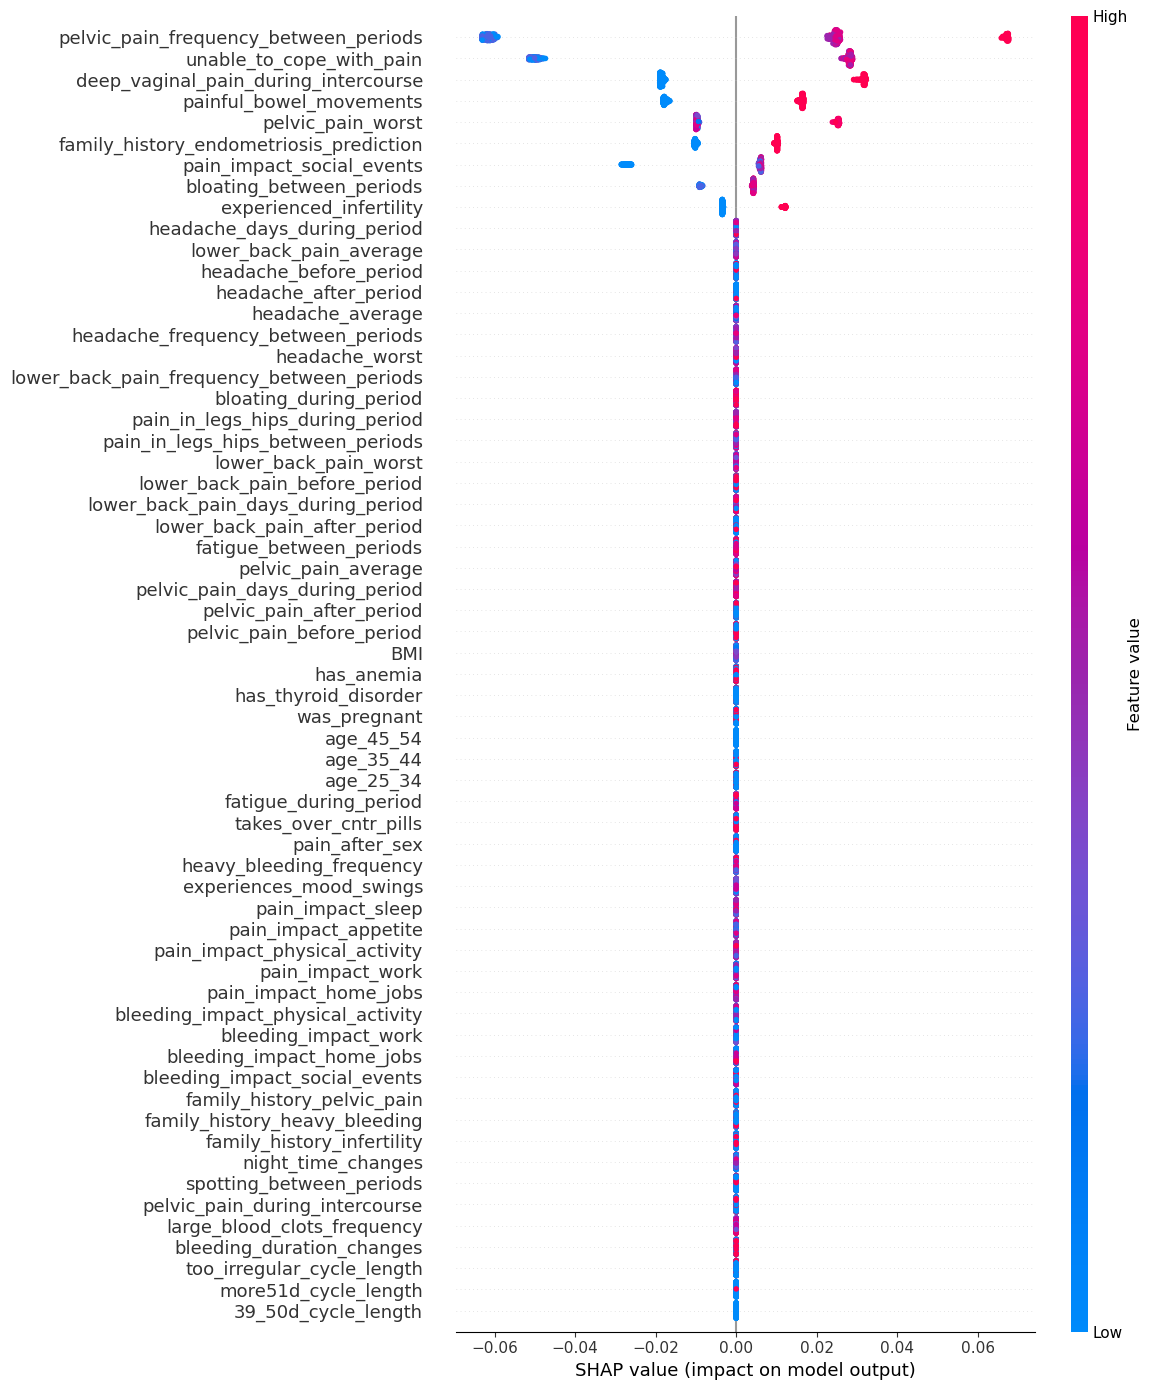

In [28]:
shap.summary_plot(shap_values_ada[:, :, 1], X_train, plot_size=[12, 14], max_display=61)

#### MLP

In [29]:
shap_values_mlp, shap_importance_mlp = feature_selection.get_shap_importance(
    pd.DataFrame(
        mlp_model_base.named_steps["scaler"].transform(X_train),
        columns=X_train.columns,
        index=X_train.index,
    ),
    mlp_model_base.named_steps["mlp"],
)

PermutationExplainer explainer: 387it [00:17, 10.35it/s]                         


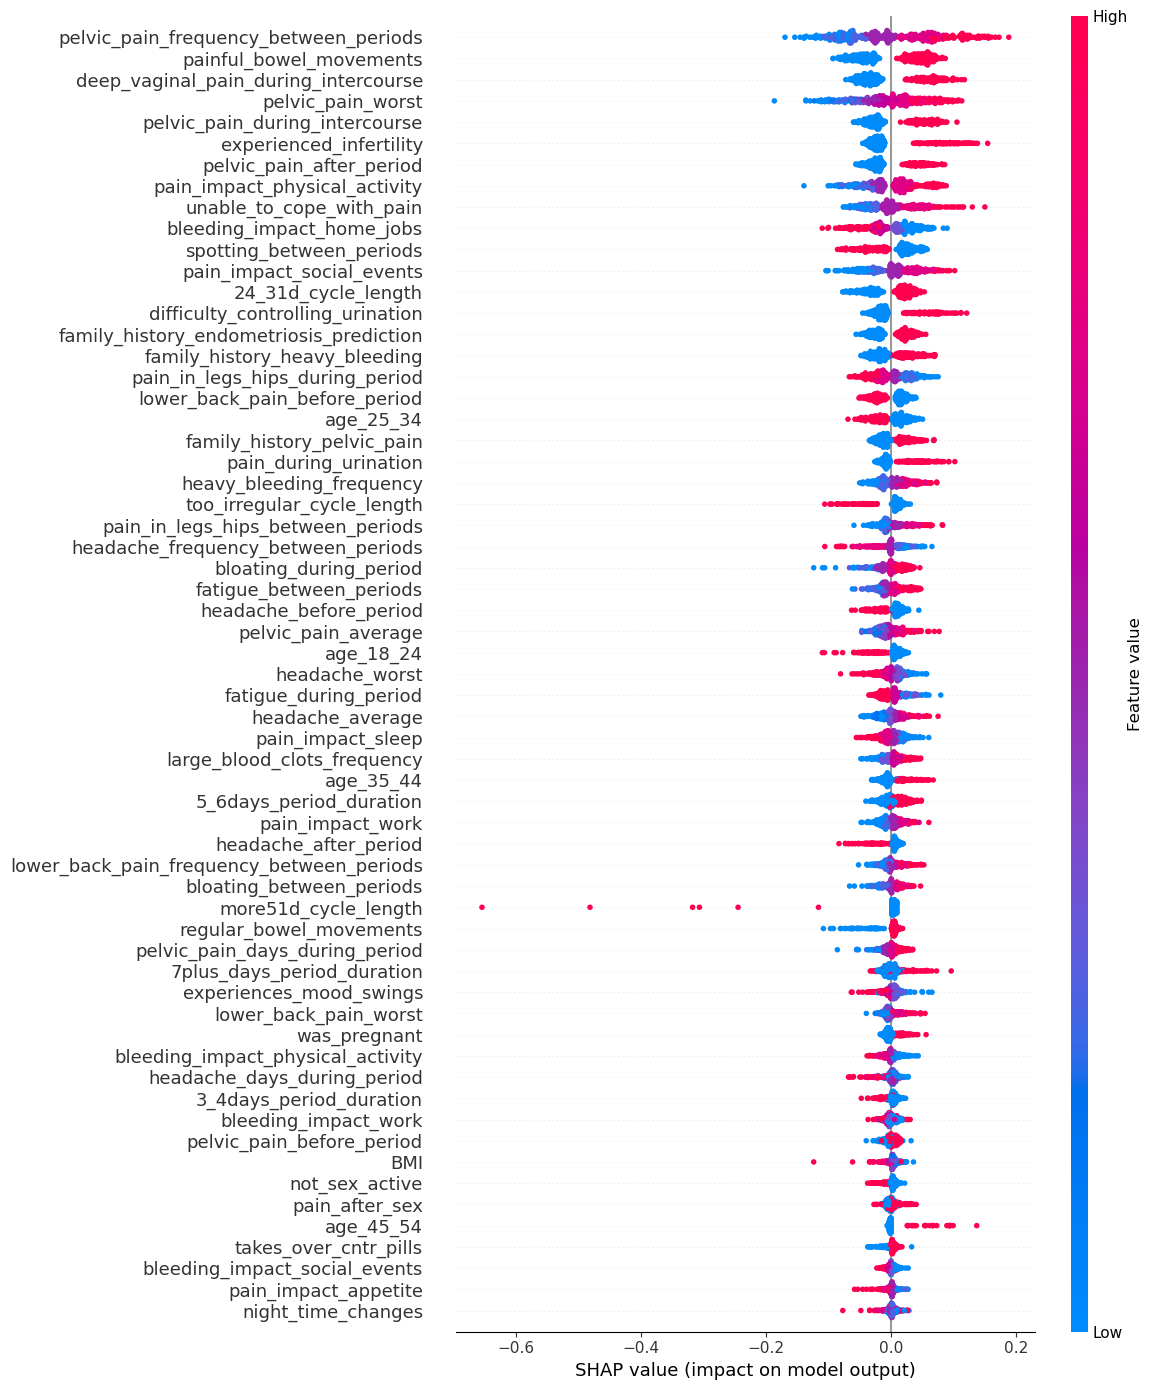

In [30]:
shap.summary_plot(shap_values_mlp[:, :, 1], X_train, plot_size=[12, 14], max_display=61)

#### TabPFN

TabPFN SHAP summary plot is presented in its corresponding notebook.

## 🥇 Feature Ranking

Feature rankings are discussed in detail under Section 6.2.1 (Feature Importance).

In [31]:
# import SHAP ranking by TabPFN in order to compare with the SHAP ranking of the other models
shap_importance_tabpfn = pd.read_csv("./tabpfn_exp_data/shap_importance_tabpfn.csv")

In [32]:
# normalize the SHAP values for all models for consistent comparison
normalized_shap_table = experiments_utils.get_normalized_shap_table(
    shap_importance_rf,
    shap_importance_xgb,
    shap_importance_ada,
    shap_importance_mlp,
    shap_importance_tabpfn,
)

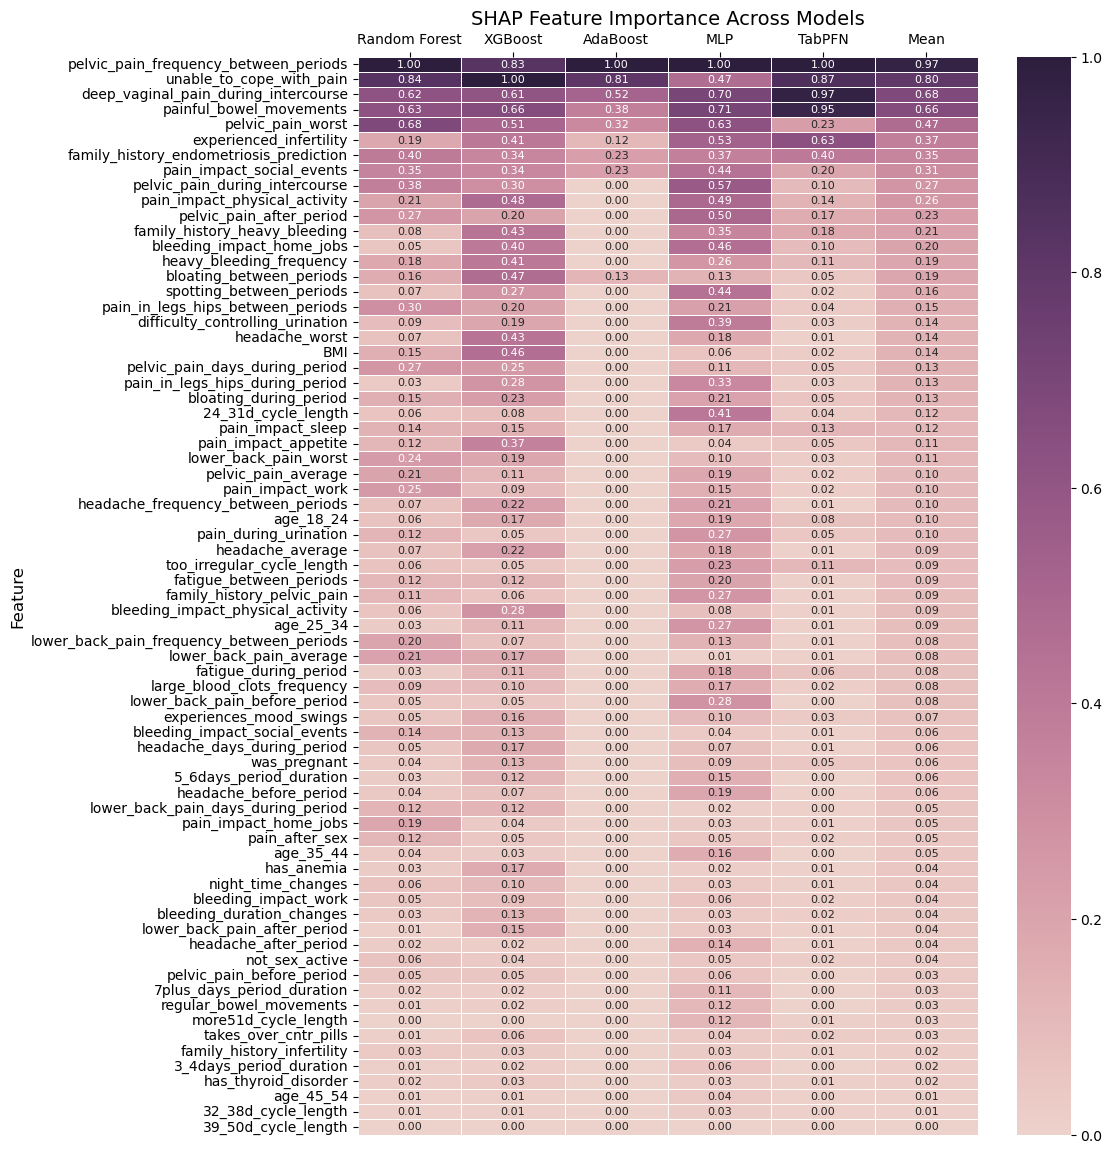

In [33]:
visual.visualize_normalized_shap_table(normalized_shap_table)

In [34]:
# save the normalized SHAP table to a csv file
# this file is used for feature selection for TabPFN (which runs in its separate notebook)
normalized_shap_table.to_csv("./tabpfn_exp_data/normalized_shap_table.csv", index=True)

## 🔍 Feature Selection

Here, we identify the subset of features that allows the model to achieve the highest possible cross-validation (CV) F1 score.

The results of this analysis are presented in Section 6.2.3 (Feature Selection).

The structure of the experiments is as follows:

Each model is trained on a subset of features, starting from the top-1 up to the maximum number of features, according to a specific SHAP-based ranking for a given model.

The output structure of the 'run_models_on_top_features' function is as follows:
* (1) The best-performing model based on the given SHAP ranking,
* (2) The corresponding test set, which includes only the features used during training,
* (3) The corresponding cross-validation F1 score.
* Additional outputs include F1 scores for each model trained on incremental subsets of features.


### Experiments on Top-N Features of SHAP ranking under Random Forest

In [28]:
(
    best_perf_model_rf_shap,
    X_test_set_rf_shap,
    best_f1_rf_shap,
    avg_folds_f1_lr_rf_shap,
    avg_folds_f1_rf_rf_shap,
    avg_folds_f1_xgb_rf_shap,
    avg_folds_f1_ada_rf_shap,
    avg_folds_f1_mlp_rf_shap,
) = feature_selection.run_models_on_top_features(
    X_train, y_train, X_test, shap_importance_rf, min_features=1
)

### Experiments on Top-N Features of SHAP ranking under XGBoost

In [29]:
(
    best_perf_model_xgb_shap,
    X_test_set_xgb_shapp,
    best_f1_xgb_shap,
    avg_folds_f1_lr_xgb_shap,
    avg_folds_f1_rf_xgb_shap,
    avg_folds_f1_xgb_xgb_shap,
    avg_folds_f1_ada_xgb_shap,
    avg_folds_f1_mlp_xgb_shap,
) = feature_selection.run_models_on_top_features(
    X_train, y_train, X_test, shap_importance_xgb, min_features=1
)

### Experiments on Top-N Features of SHAP ranking under AdaBoost 

In [30]:
(
    best_perf_model_ada_shap,
    X_test_set_ada_shapp,
    best_f1_ada_shap,
    avg_folds_f1_lr_ada_shap,
    avg_folds_f1_rf_ada_shap,
    avg_folds_f1_xgb_ada_shap,
    avg_folds_f1_ada_ada_shap,
    avg_folds_f1_mlp_ada_shap,
) = feature_selection.run_models_on_top_features(
    X_train, y_train, X_test, shap_importance_ada, min_features=1
)

### Experiments on Top-N Features of SHAP ranking under MLP

In [31]:
(
    best_perf_model_mlp_shap,
    X_test_set_mlp_shap,
    best_f1__mlp_shap,
    avg_folds_f1_lr_mlp_shap,
    avg_folds_f1_rf_mlp_shap,
    avg_folds_f1_xgb_mlp_shap,
    avg_folds_f1_ada_mlp_shap,
    avg_folds_f1_mlp_mlp_shap,
) = feature_selection.run_models_on_top_features(
    X_train, y_train, X_test, shap_importance_mlp, min_features=1
)

### Experiments on Top-N Features of SHAP ranking under TabPFN

In [32]:
(
    best_perf_model_tabpfn_shap,
    X_test_set_tabpfn_shapp,
    best_f1_tabpfn_shap,
    avg_folds_f1_lr_tabpfn_shap,
    avg_folds_f1_rf_tabpfn_shap,
    avg_folds_f1_xgb_tabpfn_shap,
    avg_folds_f1_ada_tabpfn_shap,
    avg_folds_f1_mlp_tabpfn_shap,
) = feature_selection.run_models_on_top_features(
    X_train, y_train, X_test, shap_importance_tabpfn, min_features=1
)

### Experiments on Top-N Features of SHAP ranking under Mean (Relative) Ranking across Models

In [33]:
(
    best_perf_model_mean_shap,
    X_test_set_mean_shapp,
    best_f1_mean_shap,
    avg_folds_f1_lr_mean_shap,
    avg_folds_f1_rf_mean_shap,
    avg_folds_f1_xgb_mean_shap,
    avg_folds_f1_ada_mean_shap,
    avg_folds_f1_mlp_mean_shap,
) = feature_selection.run_models_on_top_features(
    X_train,
    y_train,
    X_test,
    normalized_shap_table.reset_index()[["feature", "mean_importance"]],
    min_features=1,
)

### TabPFN related experiments

Please note again that all steps related to the training or evaluation of TabPFN are detailed in its corresponding notebook. The corresponding metrics (presented below) are saved in TabPFN's corresponding notebook and subsequently reloaded locally.

In [36]:
with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_rf_shap", "rb") as f:
    avg_folds_f1_tabpfn_rf_shap = pickle.load(f)

with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_xgb_shap", "rb") as f:
    avg_folds_f1_tabpfn_xgb_shap = pickle.load(f)

with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_ada_shap", "rb") as f:
    avg_folds_f1_tabpfn_ada_shap = pickle.load(f)

with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_mlp_shap", "rb") as f:
    avg_folds_f1_tabpfn_mlp_shap = pickle.load(f)

with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_tabpfn_shap", "rb") as f:
    avg_folds_f1_tabpfn_tabpfn_shap = pickle.load(f)

with open("./tabpfn_exp_data/avg_folds_f1_tabpfn_mean_shap", "rb") as f:
    avg_folds_f1_tabpfn_mean_shap = pickle.load(f)

### Performance Comparison

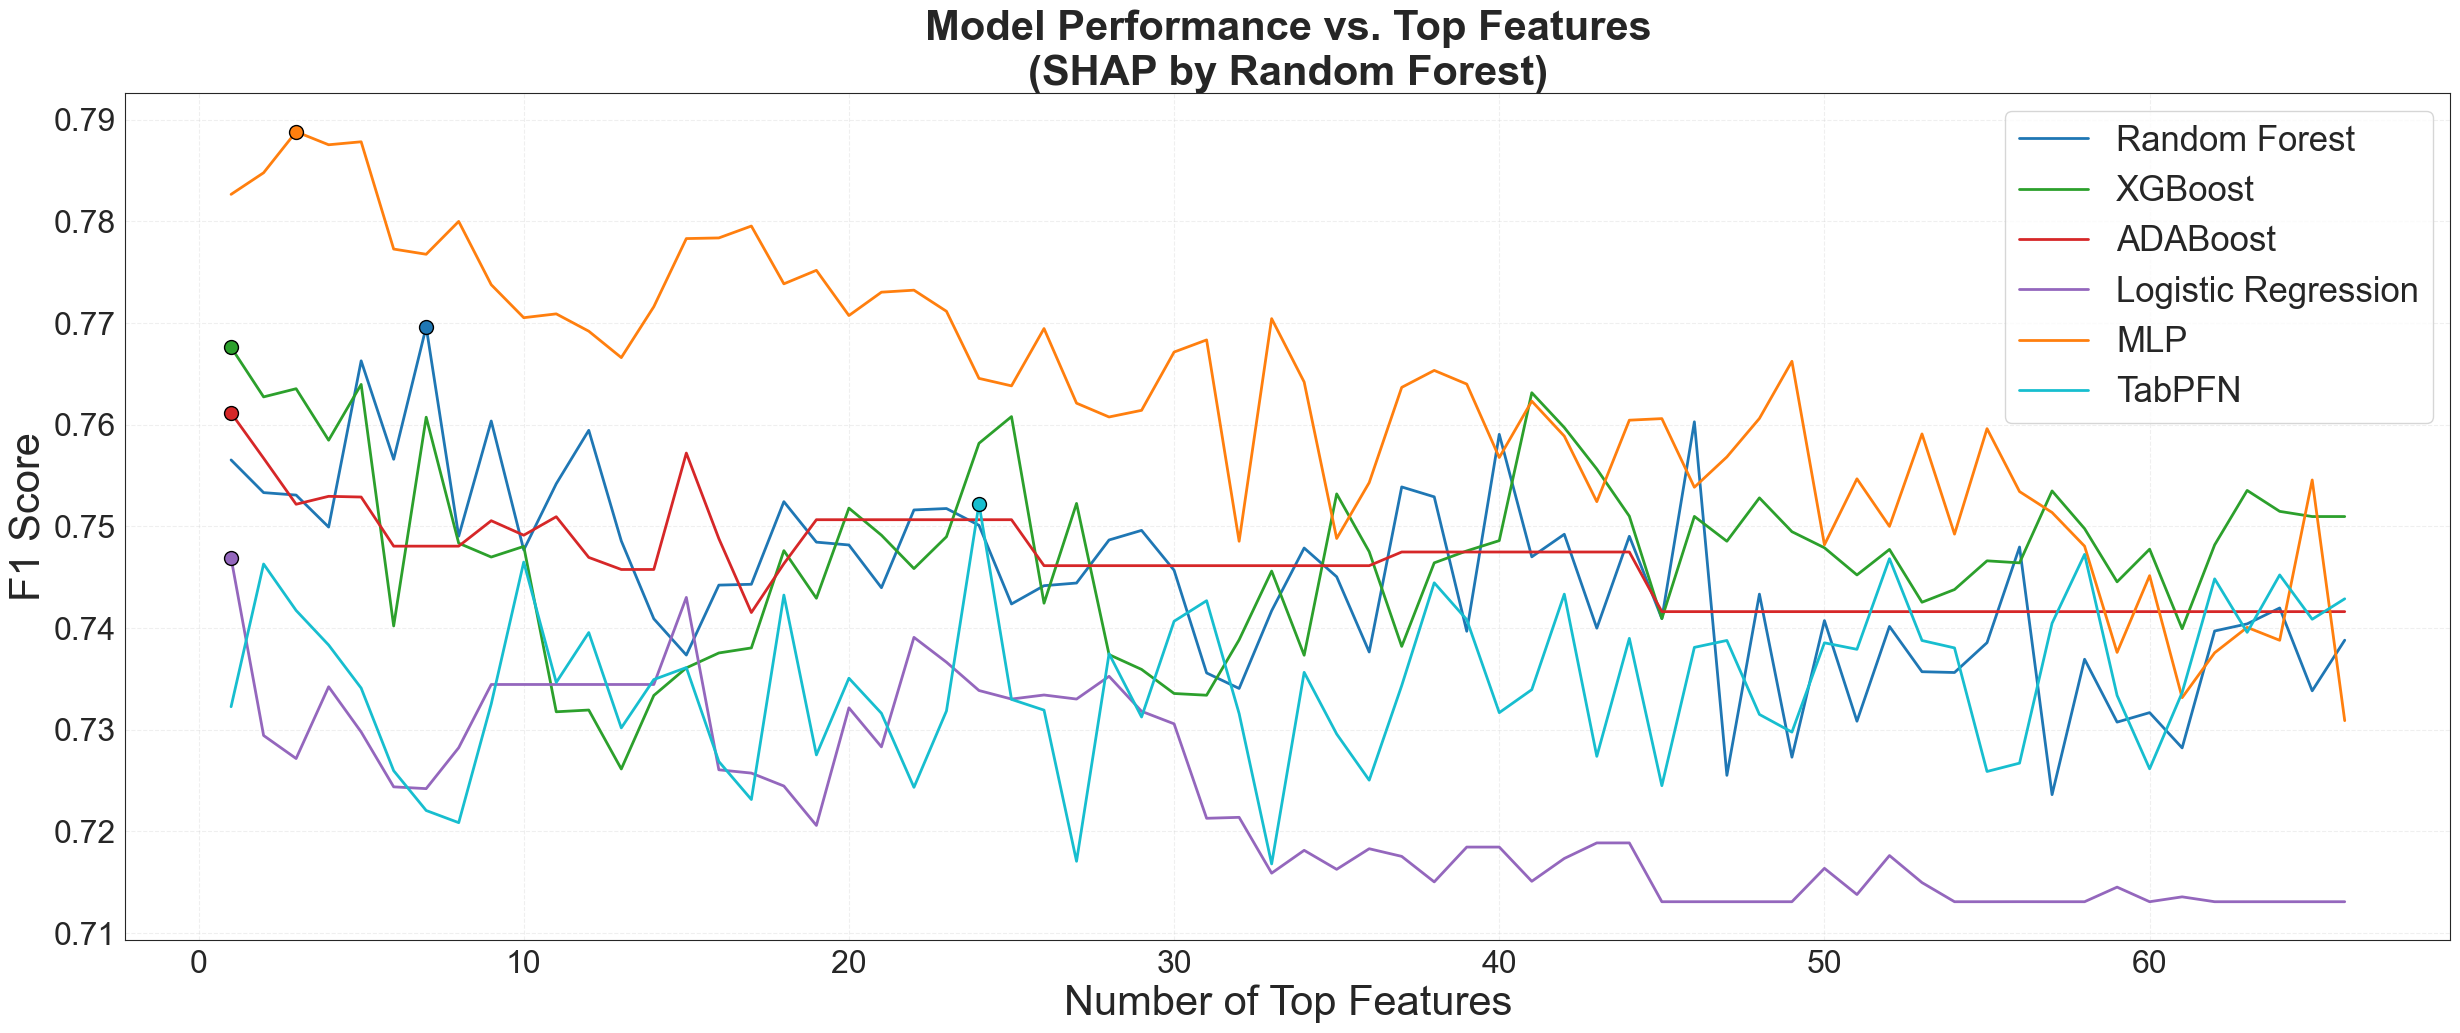

In [ ]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_rf_shap,
    avg_folds_f1_rf_rf_shap,
    avg_folds_f1_xgb_rf_shap,
    avg_folds_f1_ada_rf_shap,
    avg_folds_f1_mlp_rf_shap,
    avg_folds_f1_tabpfn_rf_shap,
    "Random Forest",
    min_features=1,
)

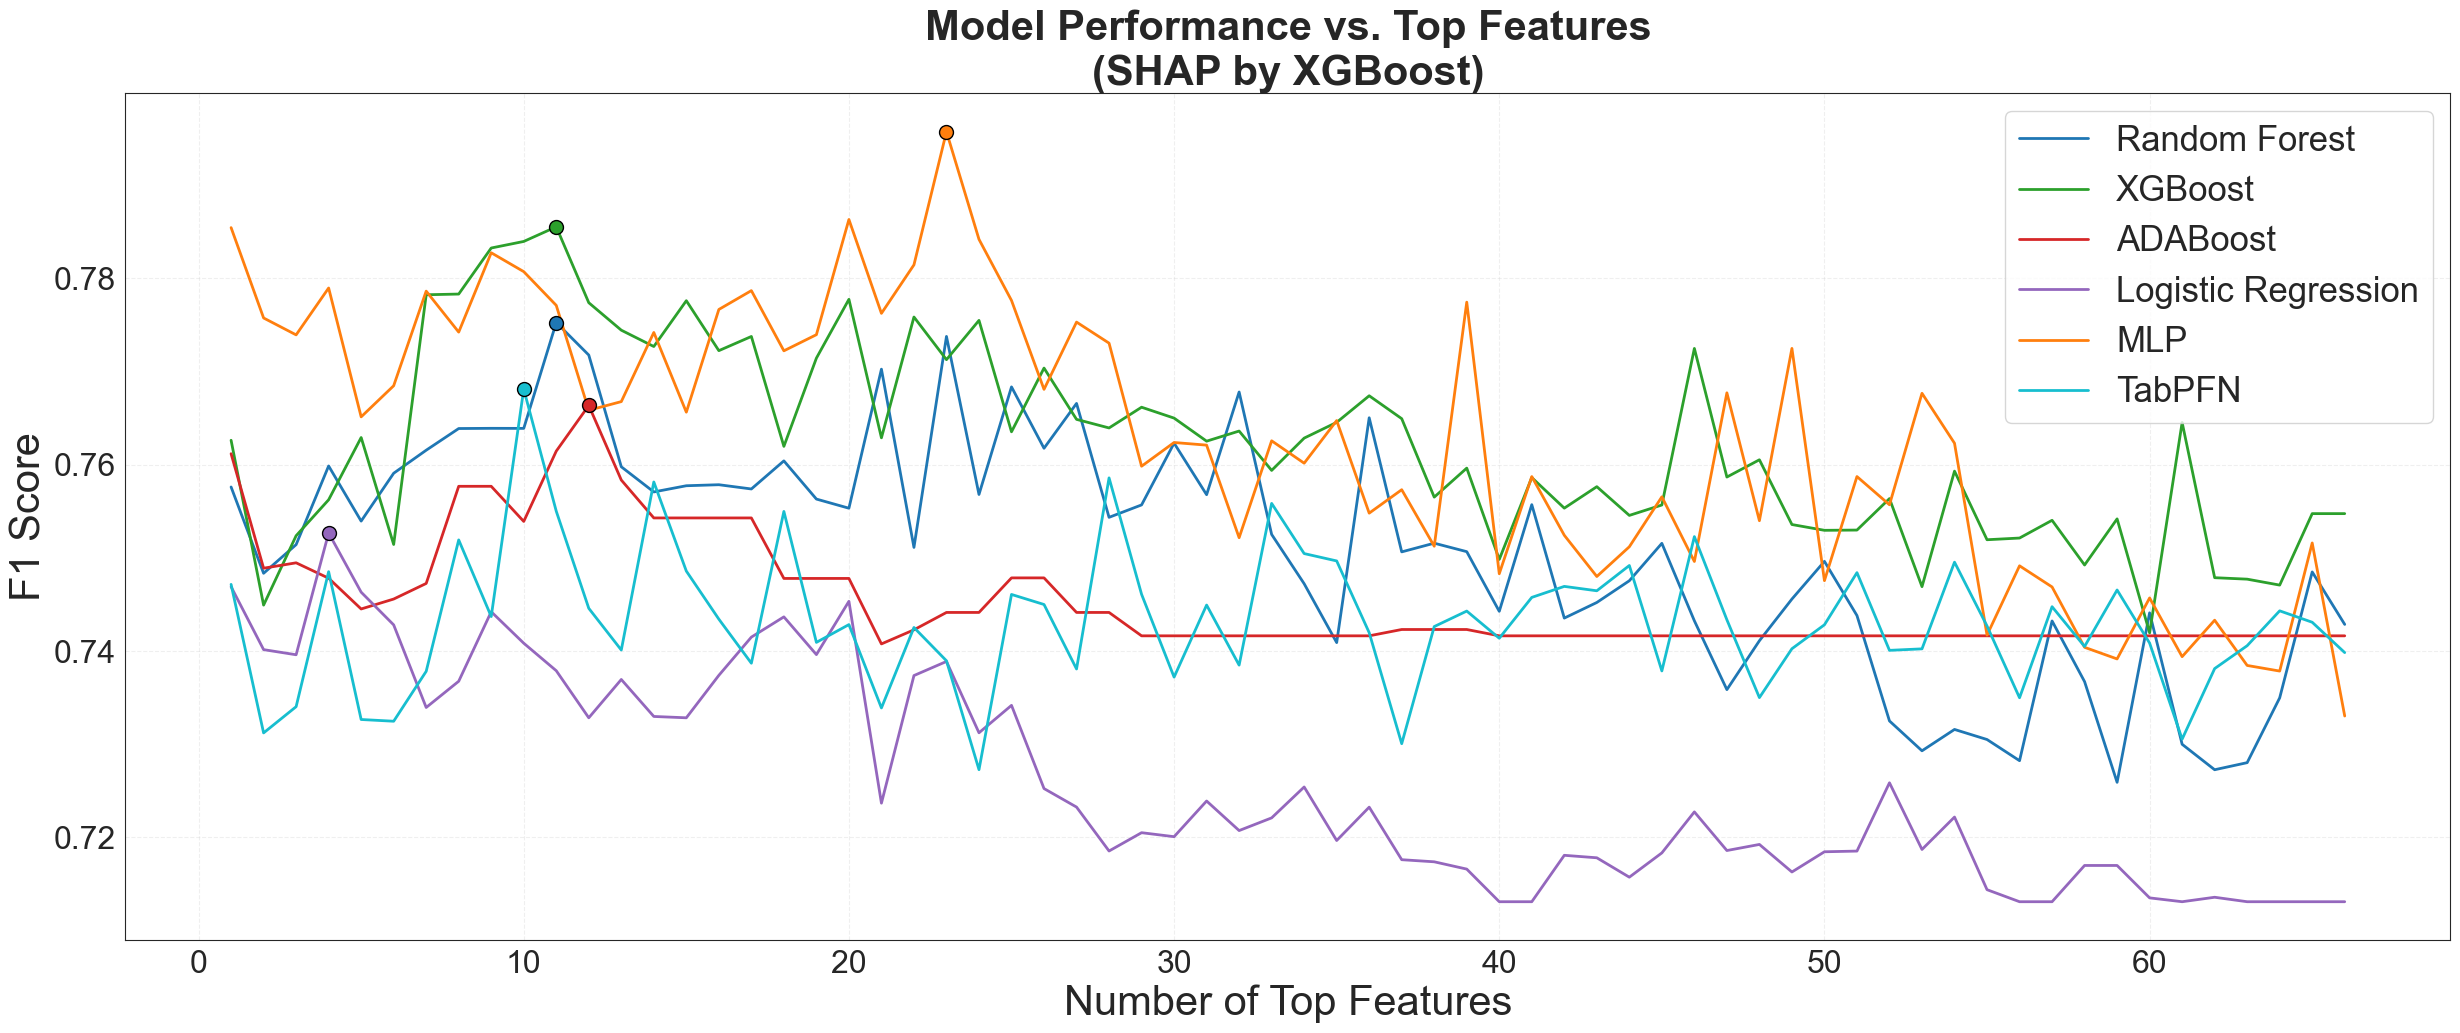

In [219]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_xgb_shap,
    avg_folds_f1_rf_xgb_shap,
    avg_folds_f1_xgb_xgb_shap,
    avg_folds_f1_ada_xgb_shap,
    avg_folds_f1_mlp_xgb_shap,
    avg_folds_f1_tabpfn_xgb_shap,
    "XGBoost",
    min_features=1,
)

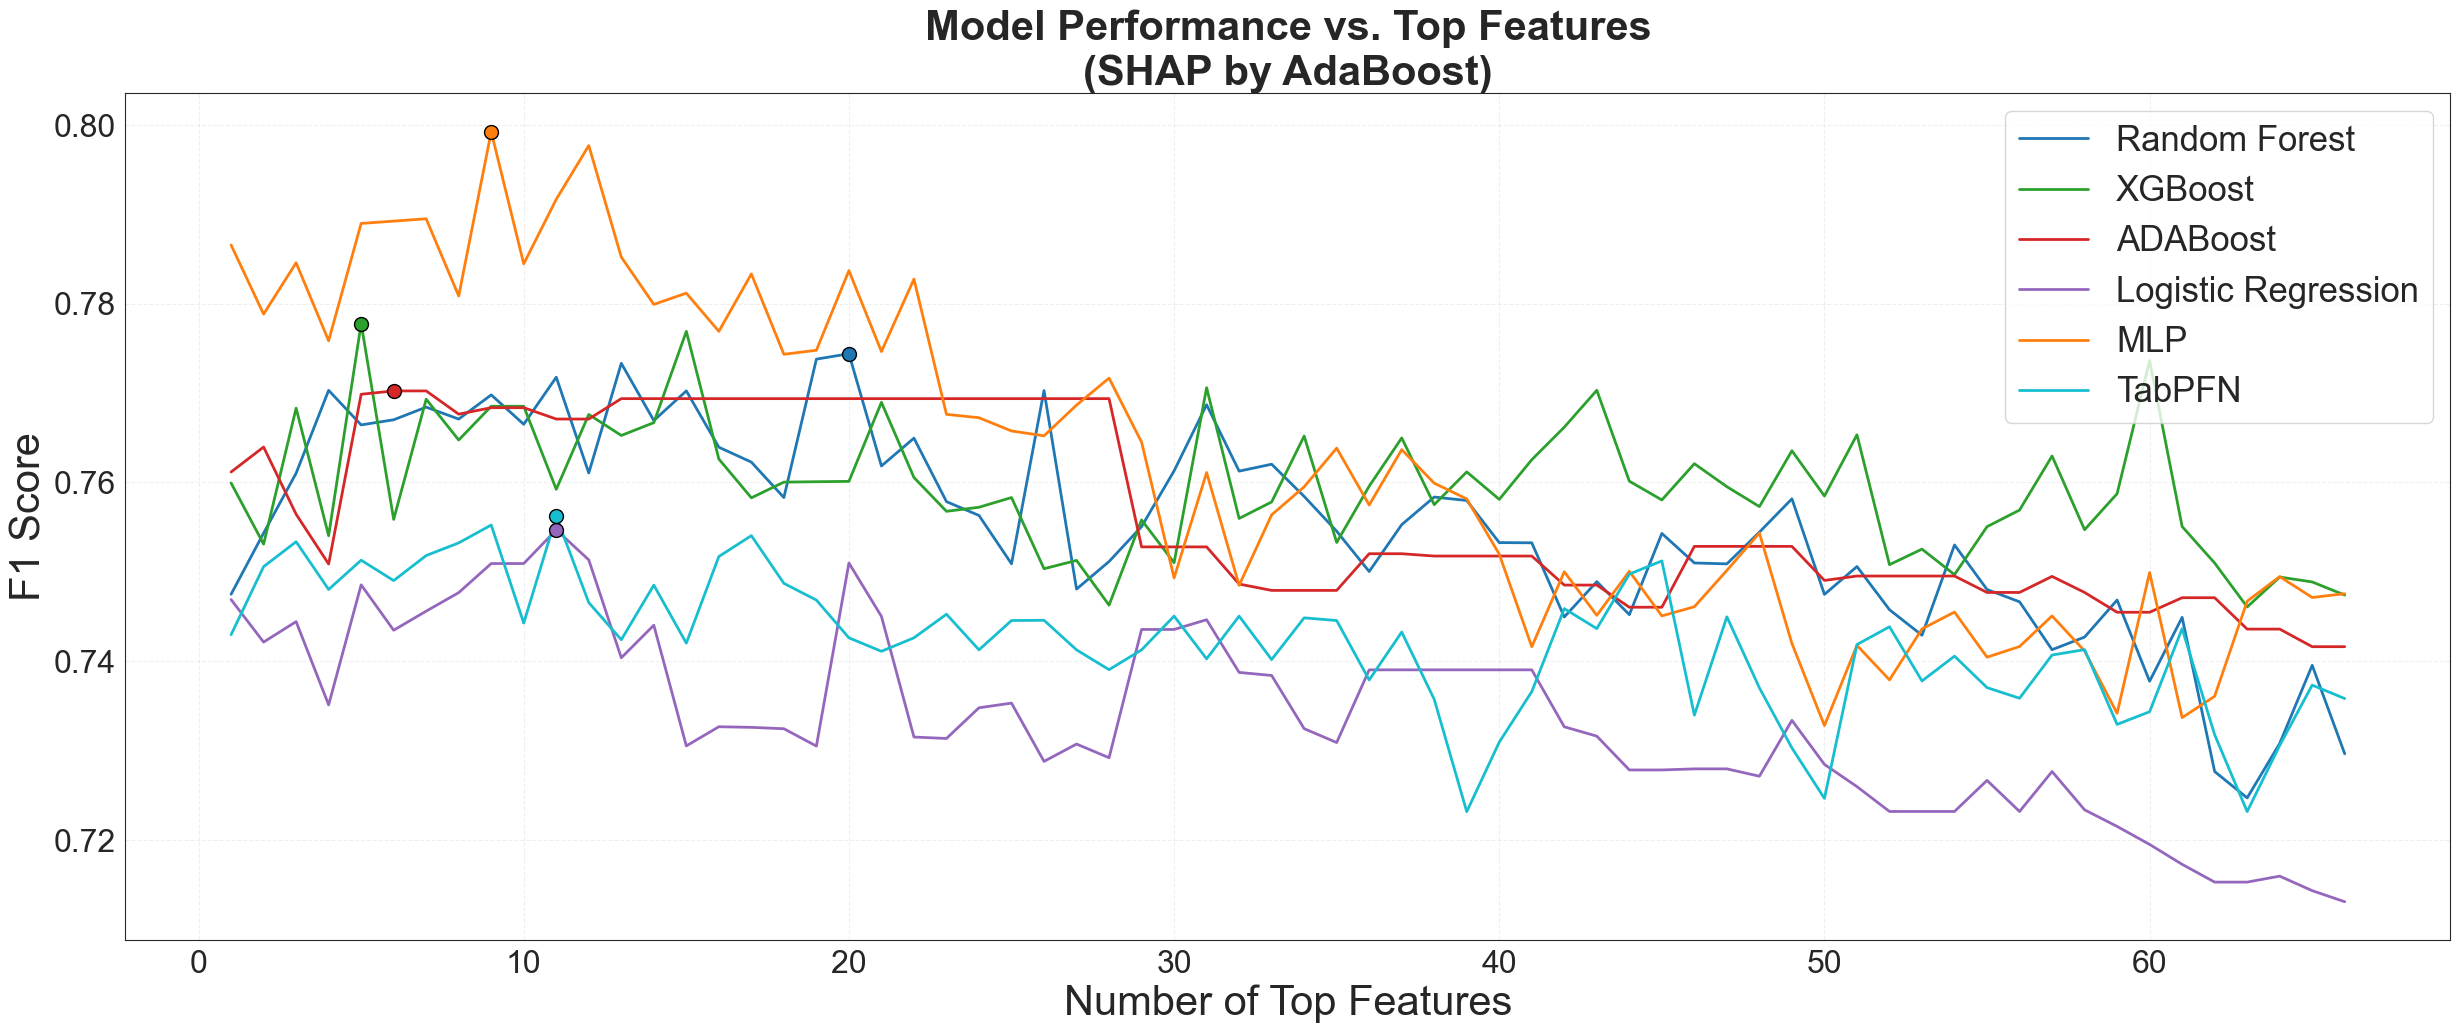

In [220]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_ada_shap,
    avg_folds_f1_rf_ada_shap,
    avg_folds_f1_xgb_ada_shap,
    avg_folds_f1_ada_ada_shap,
    avg_folds_f1_mlp_ada_shap,
    avg_folds_f1_tabpfn_ada_shap,
    "AdaBoost",
    min_features=1,
)

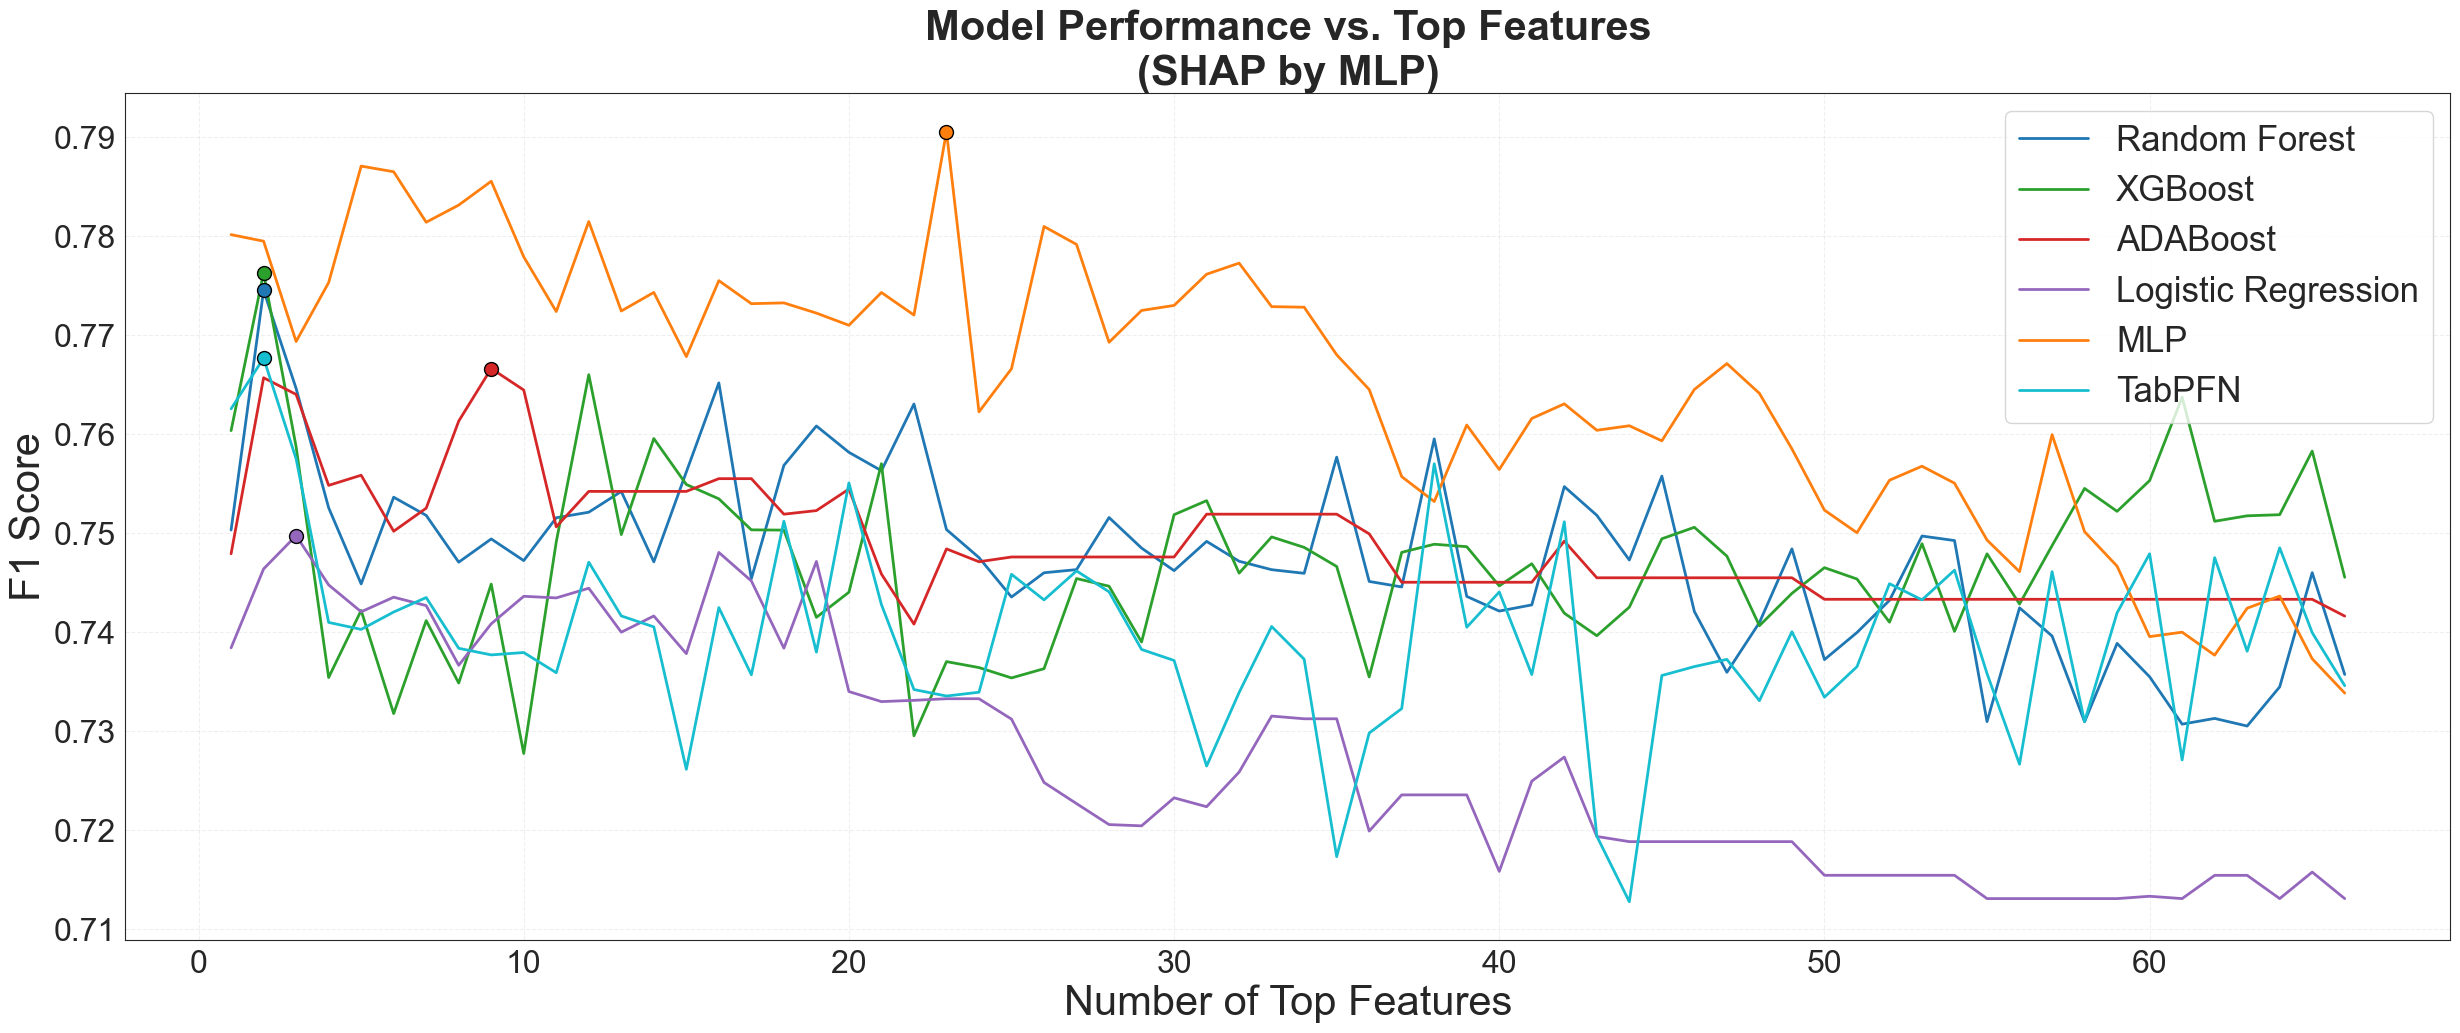

In [221]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_mlp_shap,
    avg_folds_f1_rf_mlp_shap,
    avg_folds_f1_xgb_mlp_shap,
    avg_folds_f1_ada_mlp_shap,
    avg_folds_f1_mlp_mlp_shap,
    avg_folds_f1_tabpfn_mlp_shap,
    "MLP",
    min_features=1,
)

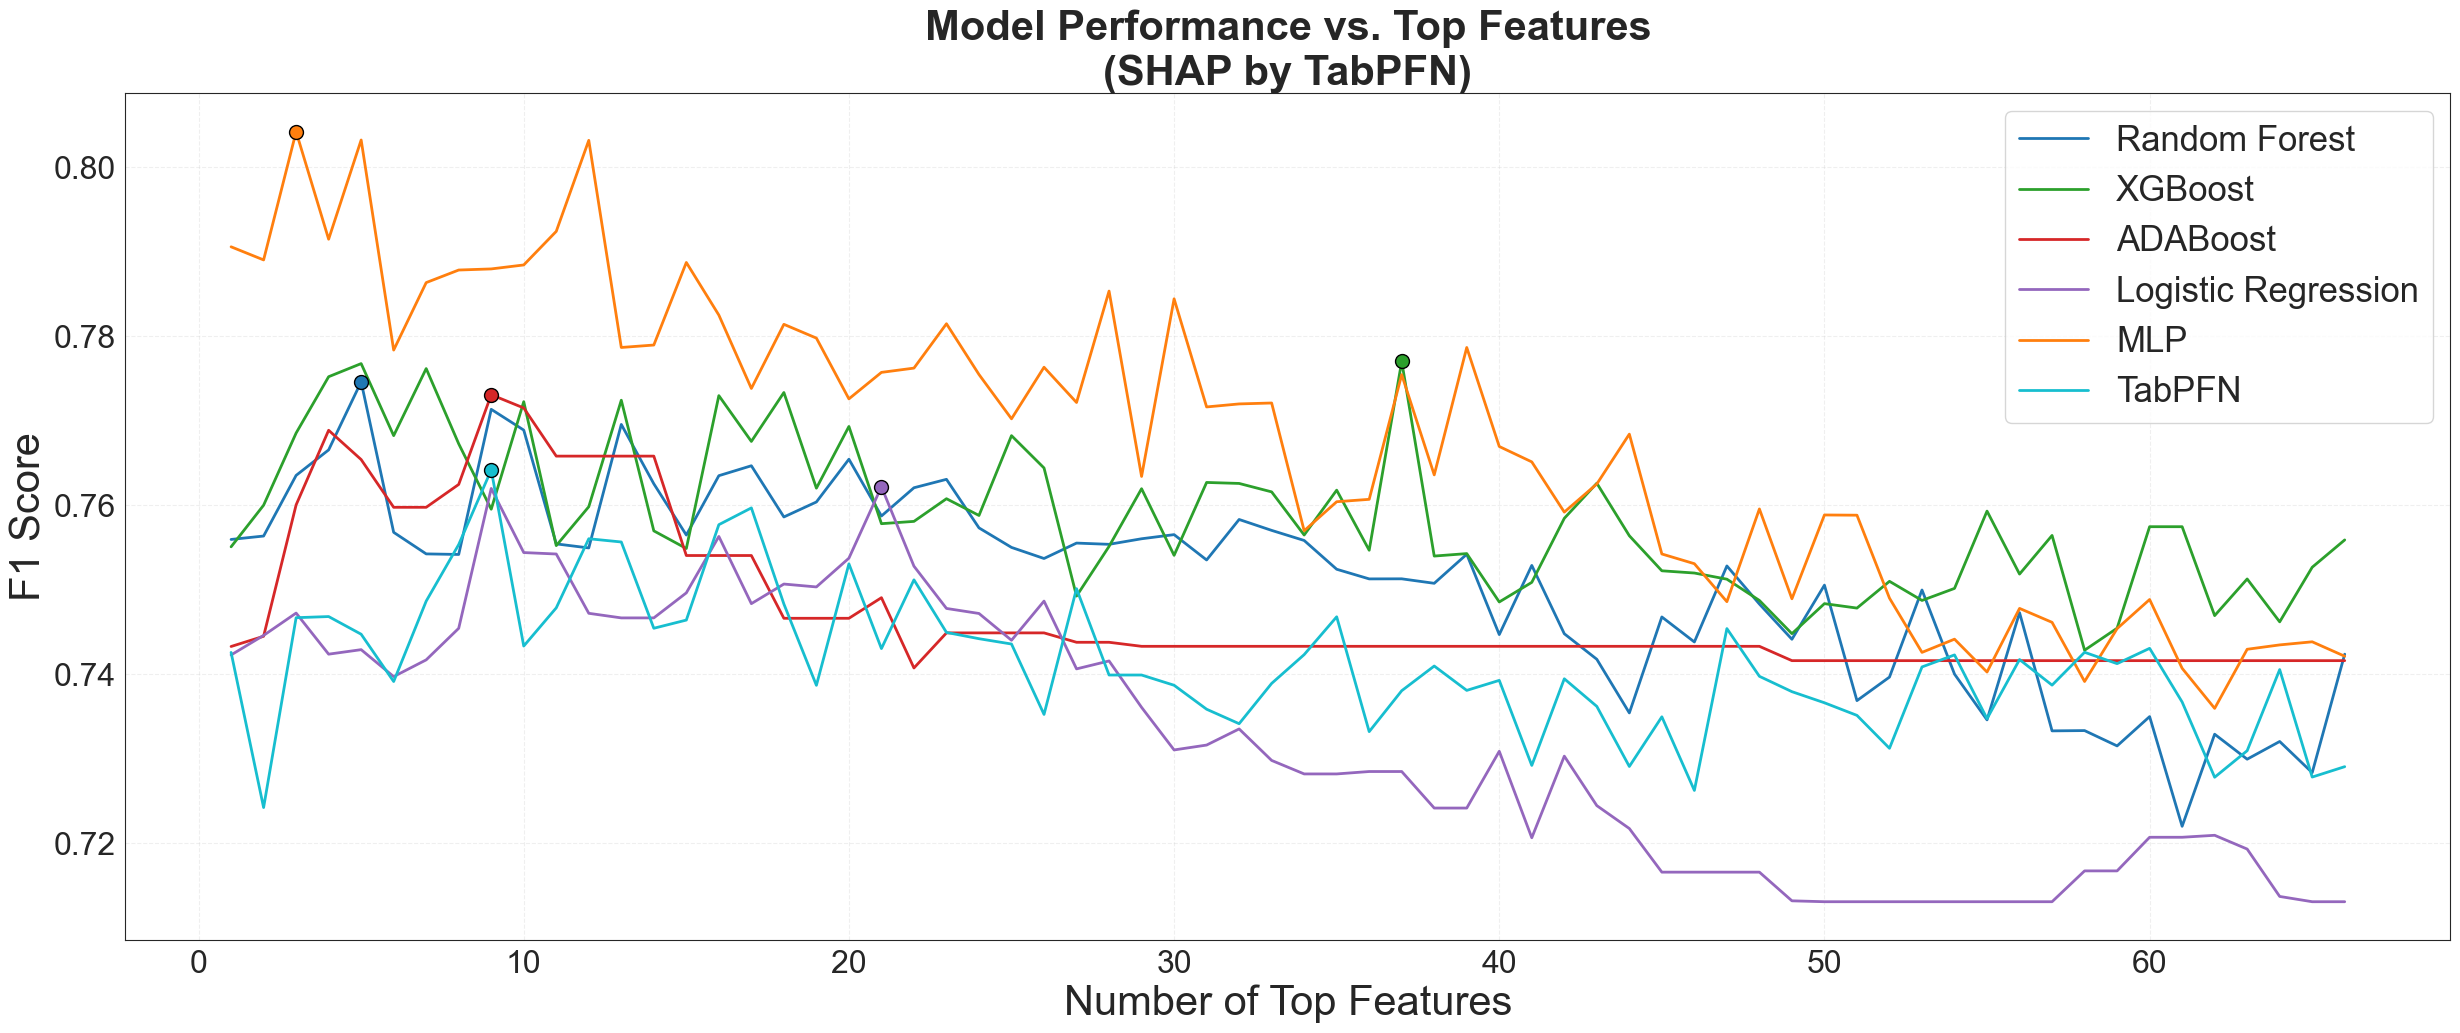

In [222]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_tabpfn_shap,
    avg_folds_f1_rf_tabpfn_shap,
    avg_folds_f1_xgb_tabpfn_shap,
    avg_folds_f1_ada_tabpfn_shap,
    avg_folds_f1_mlp_tabpfn_shap,
    avg_folds_f1_tabpfn_tabpfn_shap,
    "TabPFN",
    min_features=1,
)

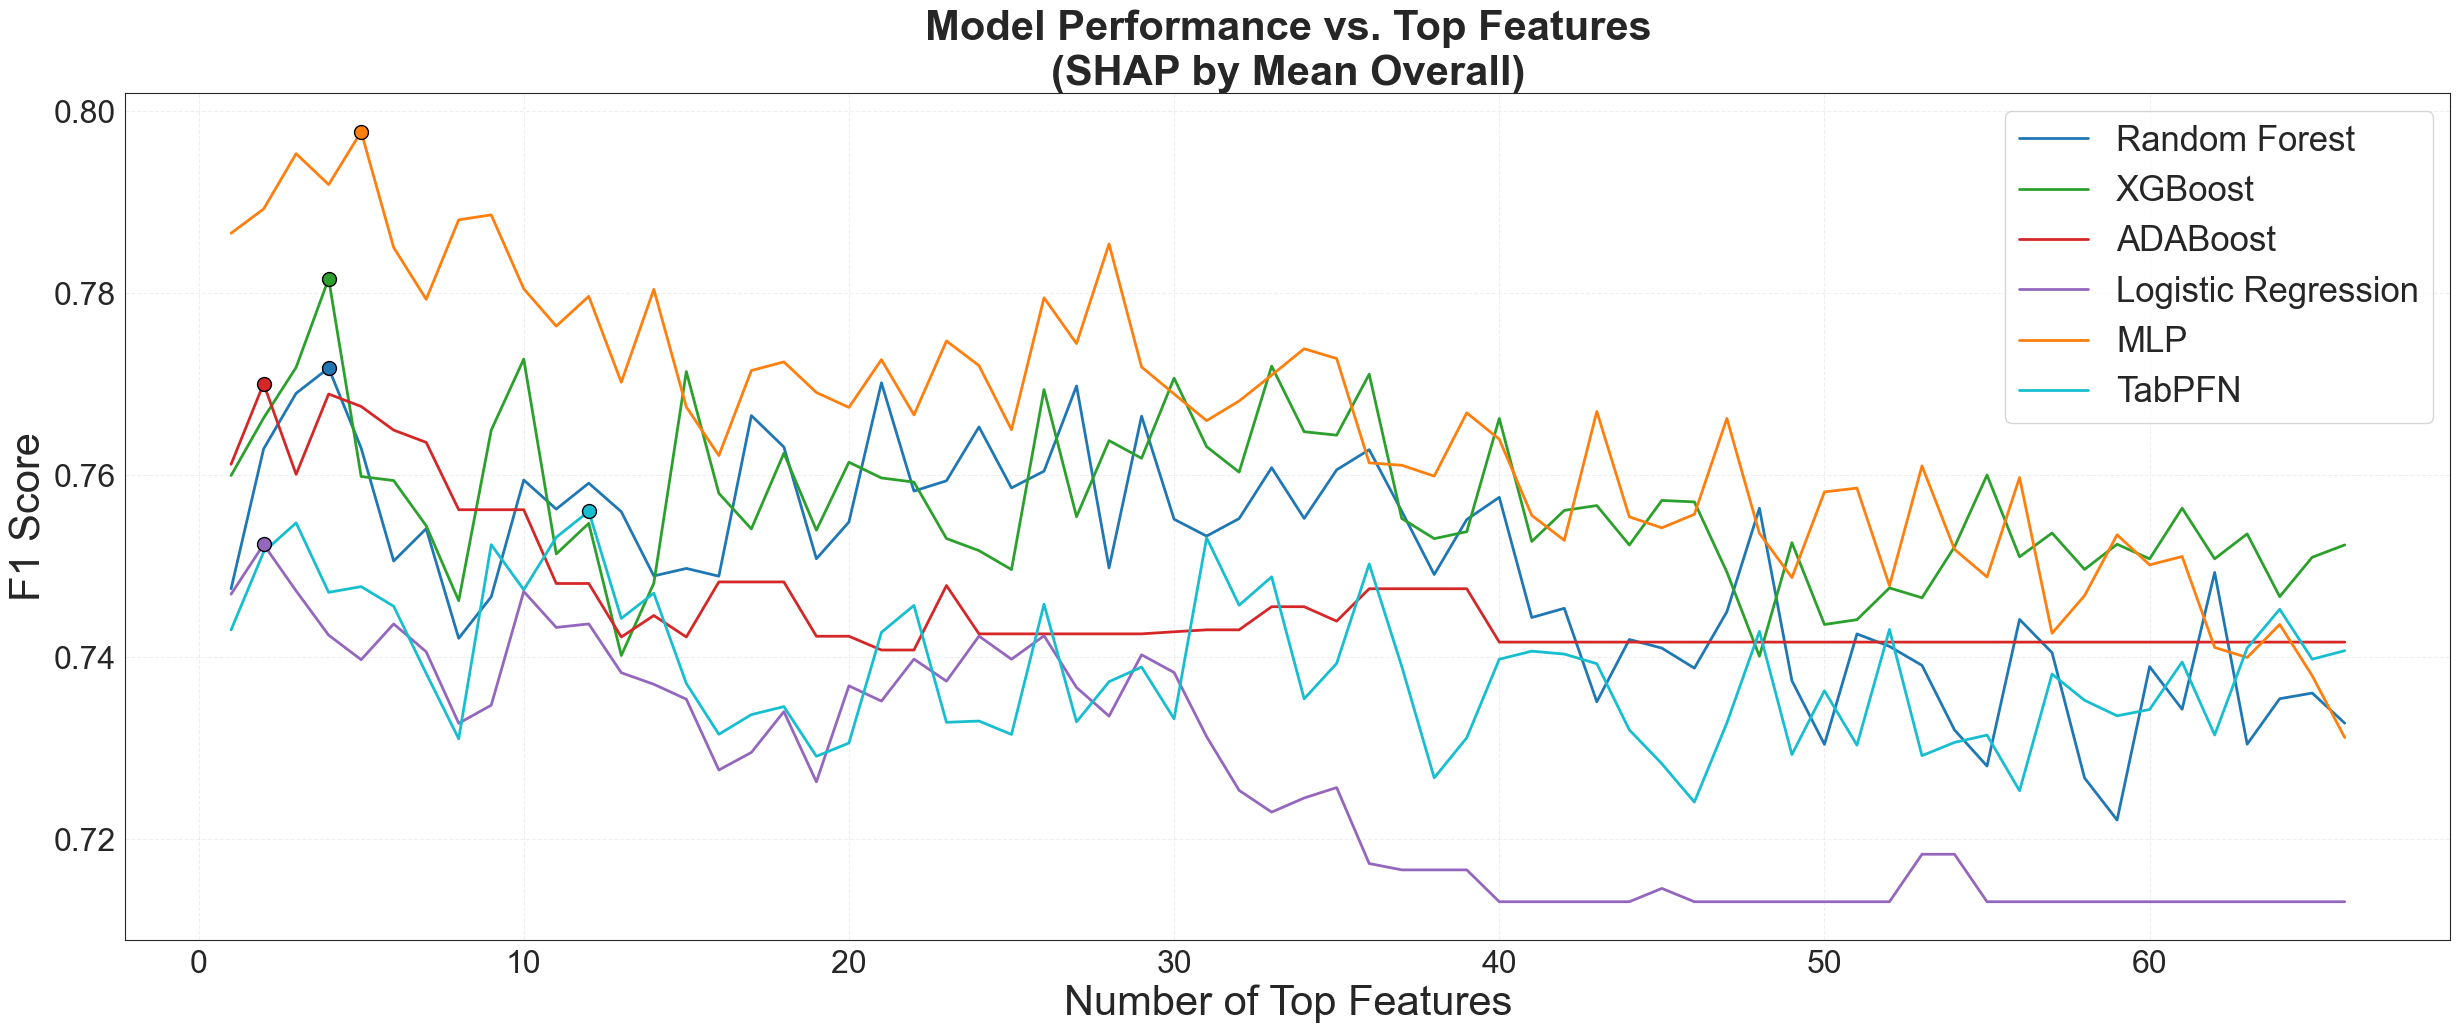

In [223]:
visual.plot_model_performance_vs_top_features(
    avg_folds_f1_lr_mean_shap,
    avg_folds_f1_rf_mean_shap,
    avg_folds_f1_xgb_mean_shap,
    avg_folds_f1_ada_mean_shap,
    avg_folds_f1_mlp_mean_shap,
    avg_folds_f1_tabpfn_mean_shap,
    "Mean Overall",
    min_features=1,
)

## 🎯 Non-Causal Modelling Evaluation

This modeling approach is described in Section 5.3 (Non-Causal Correction).

The results are discussed in the Section 6.3.1.

In [41]:
all_best_perf_model = [
    best_perf_model_rf_shap,
    best_perf_model_xgb_shap,
    best_perf_model_ada_shap,
    best_perf_model_mlp_shap,
    best_perf_model_tabpfn_shap,
    best_perf_model_mean_shap,
]
all_X_test_set = [
    X_test_set_rf_shap,
    X_test_set_xgb_shapp,
    X_test_set_ada_shapp,
    X_test_set_mlp_shap,
    X_test_set_tabpfn_shapp,
    X_test_set_mean_shapp,
]
all_best_f1 = [
    best_f1_rf_shap,
    best_f1_xgb_shap,
    best_f1_ada_shap,
    best_f1__mlp_shap,
    best_f1_tabpfn_shap,
    best_f1_mean_shap,
]

In [42]:
shap_seq = ["Random Forest", "XGBoost", "AdaBoost", "MLP", "TabPFN", "Mean Overall"]

We present the best achieved performance for each SHAP ranking, along with the corresponding number of features. This analysis aims to understand the minimum number of features required for the models to perform well.

For a comparison with experiments involving the training of the TabPFN model, please refer to the dedicated TabPFN Colab notebook. Note that the performance metrics for the TabPFN model were consistently lower than those reported below.

In [43]:
counter = 0
for best_X_test_set, best_perf_model, best_f1 in zip(
    all_X_test_set, all_best_perf_model, all_best_f1
):
    print(f"Best performing model on SHAP ranking of the {shap_seq[counter]}:")
    print(f"F1 score of {best_f1}.")
    print(f"Number of features: {best_X_test_set.shape[1]}\n")
    counter += 1

Best performing model on SHAP ranking of the Random Forest:
F1 score of 0.7888243182318169.
Number of features: 7

Best performing model on SHAP ranking of the XGBoost:
F1 score of 0.7957166772086983.
Number of features: 27

Best performing model on SHAP ranking of the AdaBoost:
F1 score of 0.7992346769579084.
Number of features: 13

Best performing model on SHAP ranking of the MLP:
F1 score of 0.7905406072051682.
Number of features: 27

Best performing model on SHAP ranking of the TabPFN:
F1 score of 0.8042221444609687.
Number of features: 7

Best performing model on SHAP ranking of the Mean Overall:
F1 score of 0.797714626391097.
Number of features: 9



In [44]:
# index of best performing model based on the F1 score
best_index = all_best_f1.index(max(all_best_f1))

In [226]:
# features used by best-performing model (basically top-7 of TabPFN SHAP ranking)
selected_features_exp = list(all_X_test_set[best_index].columns)
selected_features_exp

['pelvic_pain_frequency_between_periods',
 'deep_vaginal_pain_during_intercourse',
 'painful_bowel_movements',
 'unable_to_cope_with_pain',
 'experienced_infertility',
 'family_history_endometriosis_prediction',
 'pelvic_pain_worst']

In [45]:
# check the hyperparameters of the best performing model
all_best_perf_model[best_index]

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.1, batch_size=32,
                               beta_1=0.99, early_stopping=True,
                               hidden_layer_sizes=(50,), learning_rate_init=0.1,
                               max_iter=500, random_state=42))])

In [46]:
# evaluation metrics for non-causal modelling approach
y_test_pred = feature_selection.evaluate_model_performance(
    all_best_perf_model[best_index], all_X_test_set[best_index], y_test
)

Confusion Matrix:
[[89 13]
 [14 50]]
Accuracy: 0.8373
Recall: 0.7812
Specificity: 0.8725
F1-Score: 0.7874


## 🛠️ Manual Bias Correction Modelling Evaluation

This modeling approach is described in Section 5.4 (Manual Bias Correction).

The results are discussed in the Section 6.4.2.

In [397]:
# extract all features for the evaluated test set
_, X_test_all_info, _, _ = train_test_split(
    df_endo[experiments_utils.ALL_AVAILABLE_FEATURES], y, test_size=0.3, random_state=42
)

In [398]:
# set actual and predicted labels of endometriosis to determine False Positives and False Negatives
misclassified = pd.DataFrame(X_test_all_info, columns=X_test_all_info.columns)
misclassified["Actual"] = y_test.values
misclassified["Predicted"] = y_test_pred

In [399]:
false_positives = misclassified[
    (misclassified["Actual"] == 0) & (misclassified["Predicted"] == 1)
]
false_negatives = misclassified[
    (misclassified["Actual"] == 1) & (misclassified["Predicted"] == 0)
]

### False Positives (FP)

In [400]:
print(f"False Positives: {len(false_positives)} cases")

False Positives: 13 cases


In [2]:
false_positives_cond_mentioned = (
    experiments_utils.false_positives_exclusion_criteria_counter(false_positives)
)

3 participants reported another complaint: ['Waiting for diagnosis of endo', 'suspected endo, been told by three doctors but still on waitlist', 'Uterine fibroids']

5 use hormonal contraception.

2 use hormonal treatments for pain relief.

3 use prescribed painkillers.


In [11]:
# remove those who reported other gynaecological complaint
false_positives = false_positives[
    ~false_positives["all_conditions_mentioned"].isin(false_positives_cond_mentioned)
]
print(
    f"After removing those who reported other gynaecological complaint, there are {len(false_positives)} cases of false positives left."
)

After removing those who reported other gynaecological complaint, there are 10 cases of false positives left.


In [12]:
# remove those who take hormonal contraception
false_positives = false_positives[
    false_positives["takes_hormones_only_for_contracep"] == 0
]
print(
    f"After removing those who take hormonal contraception, there are {len(false_positives)} cases of false positives left."
)

After removing those who take hormonal contraception, there are 8 cases of false positives left.


In [14]:
# remove those who take hormonal treatments for pain relief
false_positives = false_positives[false_positives["takes_hormones_for_pain"] == 0]
print(
    f"After removing those who take hormonal treatments for pain relief, there are {len(false_positives)} cases of false positives left."
)

After removing those who take hormonal treatments for pain relief, there are 6 cases of false positives left.


In [16]:
# remove those who take prescribed painkillers
false_positives = false_positives[false_positives["takes_presc_painkillers"] == 0]
print(
    f"After removing those who take prescribed painkillers, there are {len(false_positives)} cases of false positives left."
)

After removing those who take prescribed painkillers, there are 5 cases of false positives left.


### False Negatives (FN)

In [408]:
print(f"False Negatives: {len(false_negatives)} cases")

False Negatives: 14 cases


In [409]:
experiments_utils.false_negatives_exclusion_criteria_counter(false_negatives)

Reported another complaint: 'I have not been formally diagnosed with endometriosis, but often I have been told by specialists here in the US I just must deal with the pain, the bleeding, etc. I've been to so many so-called specialists who tell me I just need to get over it. My current gynecologist thinks I have adenomyosis. I cannot take hormonal BC as it makes me violently depressed and angry, and doesn't help anyway. Thank you Kateryna! I hope you are staying safe!'

2 use hormonal contraception.

6 use hormonal treatments for pain relief.

0 participants are aged 45-54.

7 participants were pregnant.

4 use prescribed painkillers.



In [4]:
# remove those who take hormonal treatments for pain relief
false_negatives = false_negatives[false_negatives["takes_hormones_for_pain"] == 0]
print(
    f"After removing those who take hormonal treatments for pain relief, there are {len(false_negatives)} cases of false negatives left."
)

After removing those who take hormonal treatments for pain relief, there are 8 cases of false negatives left.


In [6]:
# remove those with other complaint
false_negatives_cond_mentioned = [
    "I have not been formally diagnosed with endometriosis, but often I have been told by specialists here in the US I just must deal with the pain, the bleeding, etc. I've been to so many so-called specialists who tell me I just need to get over it. My current gynecologist thinks I have adenomyosis. I cannot take hormonal BC as it makes me violently depressed and angry, and doesn't help anyway. Thank you Kateryna! I hope you are staying safe!"
]
false_negatives = false_negatives[
    ~false_negatives["suggestions_questions"].isin(false_negatives_cond_mentioned)
]
print(
    f"After removing those who reported other gynaecological complaint, there are {len(false_negatives)} cases of false negatives left."
)

After removing those who reported other gynaecological complaint, there are 7 cases of false negatives left.


In [8]:
# remove those aged 45-54
false_negatives = false_negatives[false_negatives["age_45_54"] == 0]
print(
    f"After removing those aged 45-54, there are {len(false_negatives)} cases of false negatives left."
)

After removing those aged 45-54, there are 7 cases of false negatives left.


In [9]:
# remove those who were pregnant
false_negatives = false_negatives[false_negatives["was_pregnant"] == 0]
print(
    f"After removing those who were pregnant, there are {len(false_negatives)} cases of false negatives left."
)

After removing those who were pregnant, there are 4 cases of false negatives left.


Hence, we reduced the number of false positives from 13 to 5 and false negatives from 14 to 1.

The resulting metrics:

* Confusion Matrix:
[[89, 5],
 [4, 50]]

* Accuracy: 0.9392
* Recall: 0.9259
* Specificity: 0.9468
* F1-Score: 0.9174